--- Starting Training on cuda ---
Epoch 10 | Avg Outer Loss: 3.9140
  Sample Hyperparams -> LR: 0.1172
Epoch 50 | Avg Outer Loss: 3.9081
  Sample Hyperparams -> LR: 0.0857
Epoch 100 | Avg Outer Loss: 3.9364
  Sample Hyperparams -> LR: 0.1069
Epoch 150 | Avg Outer Loss: 3.8764
  Sample Hyperparams -> LR: 0.1379
Epoch 200 | Avg Outer Loss: 3.8835
  Sample Hyperparams -> LR: 0.0952
Epoch 250 | Avg Outer Loss: 3.8609
  Sample Hyperparams -> LR: 0.1070
Epoch 300 | Avg Outer Loss: 3.8784
  Sample Hyperparams -> LR: 0.1169
Epoch 350 | Avg Outer Loss: 3.8897
  Sample Hyperparams -> LR: 0.1126
Epoch 400 | Avg Outer Loss: 3.8871
  Sample Hyperparams -> LR: 0.0955
Epoch 450 | Avg Outer Loss: 3.8370
  Sample Hyperparams -> LR: 0.0886
Epoch 500 | Avg Outer Loss: 3.8679
  Sample Hyperparams -> LR: 0.1260
--- Training complete ---
--- Evaluating Recall Accuracy ---
--- Recall Accuracy by Offset ---
Offset 0 | Accuracy: 0.083 | Observations: 1000
Offset 1 | Accuracy: 0.058 | Observations: 980
Offset 2

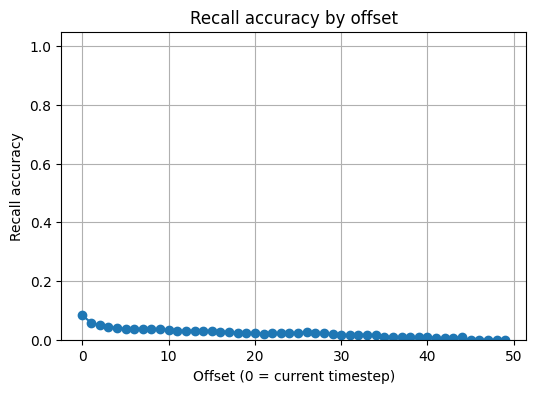

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import numpy as np
import matplotlib.pyplot as plt
from torch.func import functional_call

from func_memory_module import TTTMLP, WeightModel, HyperparamModel
from synthetic_datasets import InContextRecallDataset
from meta_optimizers import ManualAdam
from losses import windowed_p_loss, windowed_recall_cross_entropy
from evaluate_functions import (
    compute_recall_accuracies,
    average_accuracy_across_sequences,
)



# --- Configuration ---
device_type = "cuda"  # Set to "cuda" for GPU or "cpu" to force CPU
if device_type == "cuda" and not torch.cuda.is_available():
    print("CUDA not available; falling back to CPU.")
    device_type = "cpu"
device = torch.device(device_type)

key_dim = 16
val_dim = 16
context_dim = 5  # Placeholder loss takes a single weight
seq_len = 50
num_epochs = 500  # Total number of task sequences to process
batch_size = 10
assert num_epochs % batch_size == 0, "batch_size must divide num_epochs"
num_meta_updates = num_epochs // batch_size
recall_window = 1  # Number of timesteps to score in the outer loss window
# --- Evaluation Configuration ---
eval_num_sequences = 20  # Number of fresh sequences to score after training

eval_seq_len = seq_len

# --- Instantiate all meta-learning models ---
weight_model = WeightModel(key_dim, context_dim).to(device)
memory_module = TTTMLP(key_dim, val_dim).to(device)
lr_model = HyperparamModel(key_dim, initial_bias=-2.0).to(device)  # Start with LR ~0.12

# --- Instantiate optimizers ---
# The outer-loop optimizer that trains ALL meta-models
outer_optimizer = torch.optim.AdamW(
    list(memory_module.parameters()) +
    list(weight_model.parameters()) +
    list(lr_model.parameters()),
    lr=0.01
)

# --- Loss Functions ---
inner_loss_func = windowed_p_loss
outer_loss_func = nn.CrossEntropyLoss()

print(f"--- Starting Training on {device} ---")
for meta_step in range(num_meta_updates):
    # Generate a batch of new tasks (sequences) for this meta-update
    batch_datasets = []
    for _ in range(batch_size):
        dataset = InContextRecallDataset(
            seq_len=seq_len,
            key_dim=key_dim,
            val_dim=val_dim,
            context_size=context_dim,
            output_corr=0.5,
        )
        batch_datasets.append((dataset, dataset.inputs.to(device), dataset.targets.to(device)))

    # Reset inner models and optimizer states for every sequence in the batch
    fast_model = copy.deepcopy(memory_module).to(device)
    inner_optimizer = ManualAdam()

    param_sets = []
    state_list = []
    for _ in range(batch_size):
        params = {}
        for name, p in fast_model.named_parameters():
            cloned = p.detach().clone().to(device)
            cloned.requires_grad_(True)
            params[name] = cloned
        param_sets.append(params)
        state_list.append(inner_optimizer.init_states(params))

    outer_optimizer.zero_grad()
    total_outer_loss = torch.zeros((), device=device)

    # --- Inner Loop ---
    for time_index in range(seq_len):
        for task_idx, (dataset, inputs_device, targets_device) in enumerate(batch_datasets):
            current_key, current_val = dataset[time_index]
            current_key = current_key.to(device)
            current_val = current_val.to(device)

            # 1. Get dynamic parameters from meta-models
            loss_weights = weight_model(current_key[-1])  # only current key
            hyperparams = {
                "lr": lr_model(current_key[-1]),
                "beta1": 0.95,
                "beta2": 0.99,
            }

            params = param_sets[task_idx]
            state = state_list[task_idx]

            # 2. Calculate inner loss and gradients using the fast_model
            predictions = functional_call(fast_model, params, current_key)
            inner_loss = inner_loss_func(predictions.T, current_val.T, loss_weights)
            grad_tuple = torch.autograd.grad(inner_loss, tuple(params.values()), create_graph=True)
            grads = dict(zip(params.keys(), grad_tuple))

            # 3. Step the inner optimizer for the fast_model
            updated_params, updated_state = inner_optimizer.step(params, grads, state, **hyperparams)
            param_sets[task_idx] = updated_params
            state_list[task_idx] = updated_state

            # 4. Calculate outer loss using the updated fast_model
            outer_loss_step = windowed_recall_cross_entropy(
                fast_model,
                updated_params,
                inputs_device,
                targets_device,
                time_index=time_index,
                window_size=recall_window,
                loss_fn=outer_loss_func,
            )
            total_outer_loss = total_outer_loss + outer_loss_step

    # --- Outer Loop Update (Meta-Model Training) ---
    final_outer_loss = total_outer_loss / (seq_len * batch_size)
    final_outer_loss.backward()
    outer_optimizer.step()

    processed_sequences = (meta_step + 1) * batch_size
    if meta_step == 0 or processed_sequences % 50 == 0:
        print(f"Epoch {processed_sequences} | Avg Outer Loss: {final_outer_loss.item():.4f}")
        sample_key = batch_datasets[0][1][0].unsqueeze(0)
        lr_sample = lr_model(sample_key).item()
        print(f"  Sample Hyperparams -> LR: {lr_sample:.4f}")


print("--- Training complete ---")
print("--- Evaluating Recall Accuracy ---")
was_training = memory_module.training
memory_module.eval()
accuracy_histories = []
with torch.no_grad():
    for _ in range(eval_num_sequences):
        eval_dataset = InContextRecallDataset(
            seq_len=eval_seq_len,
            key_dim=key_dim,
            val_dim=val_dim,
            context_size=context_dim,
            output_corr=0.5,
        )
        eval_keys = eval_dataset.inputs.to(device)
        eval_values = eval_dataset.targets.to(device)
        history = compute_recall_accuracies(memory_module, eval_keys, eval_values)
        accuracy_histories.append(history)

mean_accuracy, counts = average_accuracy_across_sequences(accuracy_histories)
offset_tensor = torch.arange(mean_accuracy.shape[0], device=mean_accuracy.device)
valid_mask = counts > 0
offsets_np = offset_tensor[valid_mask].cpu().numpy()
accuracies_np = mean_accuracy[valid_mask].cpu().numpy()
counts_np = counts[valid_mask].cpu().numpy()
print("--- Recall Accuracy by Offset ---")
for offset_idx, acc_val, count_val in zip(offsets_np, accuracies_np, counts_np):
    print(f"Offset {int(offset_idx)} | Accuracy: {acc_val:.3f} | Observations: {int(count_val)}")

plt.figure(figsize=(6, 4))
plt.plot(offsets_np, accuracies_np, marker='o')
plt.xlabel("Offset (0 = current timestep)")
plt.ylabel("Recall accuracy")
plt.title("Recall accuracy by offset")
plt.ylim(0.0, 1.05)
plt.grid(True)
plt.show()

if was_training:
    memory_module.train()
